In [100]:
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from IPython.display import display, clear_output
import imageio
from pathlib import Path
import time
from datetime import timedelta
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['axes', 'title']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Settings and parameters

In [115]:
### Settings and parameters
NORM_LENGTH_X = 4
NORM_LENGTH_Y = 1
SCALE = 50
LENGTH_X  = NORM_LENGTH_X * SCALE    # resolution x direction  # default 400
LENGTH_Y  = NORM_LENGTH_Y * SCALE    # resolution y direction
RHO_0     = 1      # average density
TAU       = 0.6    # collision timescale (relaxation term)
# TAU = 1
# tau = 1.9739
# tau = 0.9
N_STEPS   = 4000   # number of timesteps
# 1.7 for water
U_MAX     = 0.1    # maximum velocity of Poiseuille inflow
INLET_IDX = 0
OUTLET_IDX = LENGTH_X - 1
PIPE_LENGTH = LENGTH_Y  # L
INLET_SL = np.s_[:, 0]
OUTLET_SL = np.s_[:, LENGTH_X - 1]


base_dir = '/Users/IllarionK/Projects/master_degree'
if not os.path.exists(base_dir):
    base_dir = '/src'
frames_dir = os.path.join(base_dir, 'frames')
os.makedirs(frames_dir, exist_ok=True)
video_dir = os.path.join(base_dir, 'videos')
os.makedirs(video_dir, exist_ok=True)

### Cylinder parameters
# X.shape: (100, 400) Y shape: (100, 400)
X, Y = np.meshgrid(range(LENGTH_X), range(LENGTH_Y))
# INFO: shape the same as all space, but only partially filled with cylinder
# cylinder shape: (100, 400)
NORM_CYLINDER_RADIUS = 0.125
CYLINDER_RADIUS = int(NORM_CYLINDER_RADIUS * SCALE)
NORM_CYLINDER_DIAMETER = NORM_CYLINDER_RADIUS * 2
print("CYLINDER_RADIUS:", CYLINDER_RADIUS)
# True within cylinder boundaries
Y_SHIFT = 0
CYLINDER_MASK = (X - LENGTH_X / 4) ** 2 + (Y - LENGTH_Y / 2 + Y_SHIFT) ** 2 < (CYLINDER_RADIUS) ** 2
# pylab.imshow(CYLINDER_MASK, cmap='gray')

CYLINDER_RADIUS: 6


## Vector params

In [5]:
### Vectors params
# General params
LEFT_COL_NAMES = ["NW", "W", "SW"]
CENT_COL_NAMES = ["N", "C", "S"]
RIGHT_COL_NAMES = ["NE", "E", "SE"]
N_VECTORS = 9
VECTOR_INDEXES = np.arange(N_VECTORS)

In [6]:
# New style lattices definitions
VECTORS_VELOCITIES_X = np.array([
    [-1, 0, 1,],
    [-1, 0, 1,],
    [-1, 0, 1,],
]).reshape(-1)
VECTORS_VELOCITIES_Y = np.array([
     [1,  1,  1,],
     [0,  0,  0,],
    [-1, -1, -1,],
]).reshape(-1)
VECTORS_WEIGHTS = np.array([
    [1/36, 1/9, 1/36,],
    [1/9,  4/9, 1/9,],
    [1/36, 1/9, 1/36,],
]).reshape(-1)
LAT_LEFT_COL_SL = np.s_[:, [0, 3, 6]]
LAT_CENT_COL_SL = np.s_[:, [1, 4, 7]]
LAT_RIGHT_COL_SL= np.s_[:, [2, 5, 8]]
# 'NW' 'N' 'NE' 'W' 'C' 'E' 'SW' 'S' 'SE'
#   0   1    2   3   4   5    6   7    8
VECTORS_DIRECTIONS = np.array([
    ['NW', 'N', 'NE',],
    ['W',  'C',  'E',],
    ['SW', 'S', 'SE',],
]).reshape(-1)
assert np.all(VECTORS_DIRECTIONS[LAT_LEFT_COL_SL[1]] == LEFT_COL_NAMES)
assert np.all(VECTORS_DIRECTIONS[LAT_CENT_COL_SL[1]] == CENT_COL_NAMES)
assert np.all(VECTORS_DIRECTIONS[LAT_RIGHT_COL_SL[1]] == RIGHT_COL_NAMES)
CYL_BOUNCE_BACK_DIRECTIONS = [8, 7, 6, 5, 4, 3, 2, 1, 0]

# Predefined funstions
## Tensorflow helper methods

## Initial contisions func

In [7]:
def poiseuille_profile_old(y_phys):
    # looks like a picture from here
    # https://www.simscale.com/docs/validation-cases/hagen-poiseuille-flow/
    return 4 * U_MAX / (PIPE_LENGTH ** 2) * (y_phys * PIPE_LENGTH - y_phys * y_phys)

def poiseuille_profile_new(y_phys):
    L = 2 * CYLINDER_RADIUS  # характерный размер
    nu = U_MAX * L / RE
    G = 1 / 100000
    ux = G / (2 * nu) * y_phys * (LENGTH_Y - y_phys)
    return ux

def init_poiseuille():
    rho = 1
    y, x = np.meshgrid(np.arange(LENGTH_Y), np.arange(LENGTH_X))
    F = np.empty((LENGTH_X, LENGTH_Y, N_VECTORS))
#     y_phys = y - 0.5;
#     ux = poiseuille_profile_new(y)
    ux = poiseuille_profile_old(y)
    uy = np.zeros((LENGTH_X, LENGTH_Y))
    
    for idx in range(9):
        # 300, 100
        cu = 3 * (VECTORS_VELOCITIES_X[idx] * ux + VECTORS_VELOCITIES_Y[idx] * uy);
        # 300, 100
        res = rho * VECTORS_WEIGHTS[idx] * (1 + cu + 1/2 * cu ** 2 - 3/2*(ux**2 + uy **2));
        F[:, :, idx] = res
    F = np.rot90(F)
    return F

## Equality functions

### tf equality

In [8]:
### Tensorflow helper methods
def build_graph():
    dtype = tf.float32
    velocities_x_tf = tf.constant(VECTORS_VELOCITIES_X, dtype=dtype)
    velocities_y_tf = tf.constant(VECTORS_VELOCITIES_Y, dtype=dtype)
    weights_tf = tf.constant(VECTORS_WEIGHTS, dtype=dtype)
    
    def ones_init(shape, dtype=None, partition_info=None):
        kernel = np.zeros(shape)
        kernel[0, 0, :, 0] = 1.0
        return tf.cast(kernel, dtype)

    sum_conv = tf.keras.layers.Conv2D(1, (1, 1), kernel_initializer=ones_init)

    def vel_x_init_many_to_one(shape, dtype=None, partition_info=None):
        kernel = np.zeros(shape)
        kernel[0, 0, :, 0] = VECTORS_VELOCITIES_X
        return tf.cast(kernel, dtype)

    vel_x_conv = tf.keras.layers.Conv2D(1, (1, 1), kernel_initializer=vel_x_init_many_to_one)

    def vel_y_init_many_to_one(shape, dtype=None, partition_info=None):
        kernel = np.zeros(shape)
        kernel[0, 0, :, 0] = VECTORS_VELOCITIES_Y
        return tf.cast(kernel, dtype)

    vel_y_conv = tf.keras.layers.Conv2D(1, (1, 1), kernel_initializer=vel_y_init_many_to_one)
    return velocities_x_tf, velocities_y_tf, weights_tf, sum_conv, vel_x_conv, vel_y_conv

In [9]:
def calc_tf_eq_core(data_flat, tf_params):
    velocities_x_tf, velocities_y_tf, weights_tf, sum_conv, vel_x_conv, vel_y_conv = tf_params
#     batch = data_flat.reshape(1, *data_flat.shape)
    batch = data_flat
#     rho = sum_conv(batch)
    rho = tf.cast(tf.expand_dims(tf.math.reduce_sum(batch, axis=3), axis=-1), tf.float32)
    ux_lattices = vel_x_conv(batch) / rho
    uy_lattices = vel_y_conv(batch) / rho
    ux_elements = tf.math.multiply(ux_lattices, velocities_x_tf)
    uy_elements = tf.math.multiply(uy_lattices, velocities_y_tf)
    before_weights = (
        1 + 3 * (ux_elements + uy_elements) +
        9 * (ux_elements + uy_elements) ** 2 / 2 - 
        3 * (ux_lattices ** 2 + uy_lattices ** 2) / 2
    )
    after_weights = tf.math.multiply(before_weights, weights_tf)
    F_eq = tf.math.multiply(rho, after_weights)
#     F_eq = F_eq.numpy().squeeze()
#     print_v("F_eq_tf:\n", F_eq[0][0])
    return F_eq

calc_tf_eq_func = tf.function(calc_tf_eq_core)
TF_PARAMS = build_graph()

def calc_tf_eq(data_flat):
    batch = data_flat.reshape(1, *data_flat.shape)
    return calc_tf_eq_func(batch, TF_PARAMS).numpy().squeeze()

2021-11-28 01:12:28.130654: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-28 01:12:29.130648: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5387 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:02:00.0, compute capability: 6.1
2021-11-28 01:12:29.131922: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 5387 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:03:00.0, compute capability: 6.1


### Optimized tf

# Simulation loop

In [10]:
from tensorflow.keras import Input, Model

batch = Input(shape=(LENGTH_Y, LENGTH_Y, N_VECTORS))
velocities_x_tf, velocities_y_tf, weights_tf, sum_conv, vel_x_conv, vel_y_conv = build_graph()
# rho = sum_conv(batch)
rho = tf.expand_dims(tf.math.reduce_sum(batch, axis=3), axis=-1)
ux_lattices = vel_x_conv(batch) / rho
uy_lattices = vel_y_conv(batch) / rho
ux_elements = tf.math.multiply(ux_lattices, velocities_x_tf)
uy_elements = tf.math.multiply(uy_lattices, velocities_y_tf)
before_weights = (
    1 + 3 * (ux_elements + uy_elements) +
    9 * (ux_elements + uy_elements) ** 2 / 2 - 
    3 * (ux_lattices ** 2 + uy_lattices ** 2) / 2
)
after_weights = tf.math.multiply(before_weights, weights_tf)
F_eq = tf.math.multiply(rho, after_weights)
model = Model(inputs=batch, outputs=F_eq)
# graph_model = tf.function(model)
tf.saved_model.save(model, '/tmp/model')
loaded = tf.saved_model.load('/tmp/model')
infer = loaded.signatures["serving_default"]

def predict(data):
    data_batch = data.reshape(1, *data.shape)
    tf_res = infer(tf.constant(data_batch, dtype=tf.float32))
    np_res = tf_res[model.output_names[0]].numpy().squeeze()
    return np_res

2021-11-28 01:12:45.797466: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/model/assets


In [117]:
!ls -l /src/frames

total 84
drwxr-xr-x 2 root root  4096 Nov 28 15:38 1000_100
drwxr-xr-x 2 root root 16384 Nov 28 15:43 1000_50
drwxr-xr-x 2 root root 16384 Nov 28 15:52 100_50
drwxr-xr-x 2 root root 16384 Nov 28 15:49 200_50
drwxr-xr-x 2 root root 16384 Nov 28 15:46 500_50
drwxr-xr-x 2 root root 16384 Nov 28 15:54 60_50


## New imported version

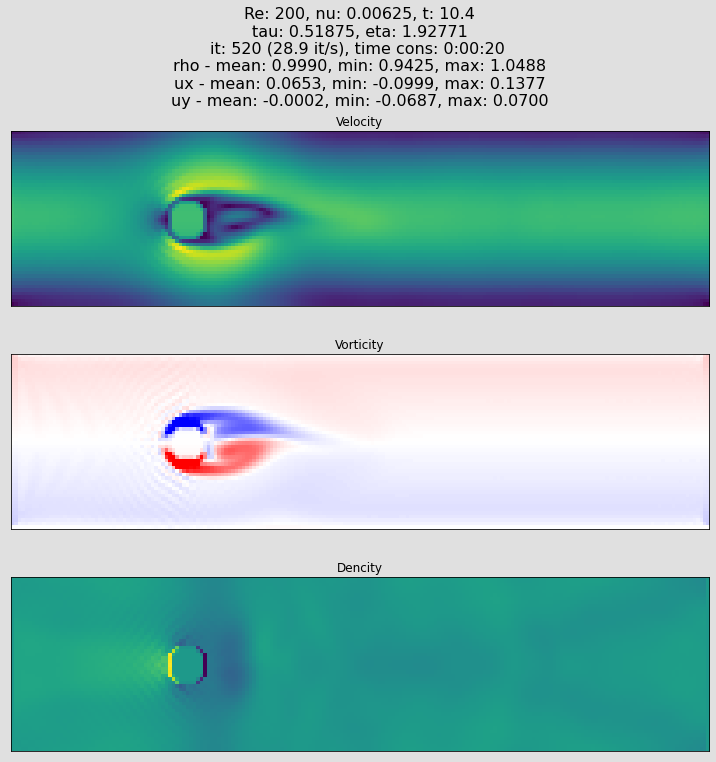

In [ ]:
from importlib import reload
import tf_transfer.tf_solver
import tf_transfer.np_solver
reload(tf_transfer.tf_solver);
reload(tf_transfer.np_solver);


for RE in [10, 60, 100, 200, 500, 1000][::-1]:
# for RE in [1000]:
    Re = RE / SCALE
    D = NORM_CYLINDER_DIAMETER
    u = U_MAX
    rho = RHO_0
    nu = u * D / Re   # Kinematic viscosity
    print(f"nu: {nu}")
    tau = 3 * nu + 1/2  # Get relaxation parameters
    print(f"tau: {tau}")
    omega = 1 / tau
    print(f"omega: {omega}")

    def prep_figure():
        fig, axes = plt.subplots(3, figsize=(10, 11))
        fig.patch.set_facecolor('#E0E0E0')
        fig.suptitle(f'Re: {RE}', fontsize=16)
        for ax in axes:
            ax.invert_yaxis()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_aspect('equal')
        fig.tight_layout()
        return fig, axes

    bwr_cmap = plt.cm.bwr.copy()
    bwr_cmap.set_bad('black')
    PLOT = False
    SAVE_RES = True
    DEBUG_PRINT = False
    if PLOT:
        fig, axes = prep_figure()
    if SAVE_RES:
        res_frame_dir = os.path.join(frames_dir, f"{RE}_{SCALE}")
        os.makedirs(res_frame_dir, exist_ok=True)

    F = init_poiseuille()
    first_col = np.copy(F[:, 0, :])
    last_col = np.copy(F[:, -1, :])
    wide_F = np.zeros((F.shape[0] + 2, F.shape[1] + 2, 9))
    start = time.time()
    global_start_time = time.time()
    
    N_STEPS = 100 * SCALE
    for it in tqdm(range(N_STEPS), disable=(PLOT or DEBUG_PRINT or SAVE_RES)):
        F = tf_transfer.tf_solver.calc(
            F, wide_F,
            cyl_mask_np=CYLINDER_MASK.astype(np.uint8),
            tau=tau,
        )
#         F = tf_transfer.np_solver.calc(
#             F, CYLINDER_MASK, tau,
#             u_max=U_MAX, pipe_length=PIPE_LENGTH,
#         )
        F[:, 0, :] = first_col
        F[:, -1, :] = last_col

        if it % 10 == 0 and it >= 2000 and DEBUG_PRINT:
            F_cp = np.copy(F)
            plot_results = tf_transfer.tf_solver.pre_plot(F_cp)
            u, vorticity, rho = plot_results
            ux  = np.sum(F * VECTORS_VELOCITIES_X, 2) / rho
            uy  = np.sum(F * VECTORS_VELOCITIES_Y, 2) / rho
            print(f"it: {it}")
            print(f'Re: {RE}, tau: {tau:.5f}, eta: {1 / tau:.5f}, it: {it} ({plot_it_per_sec:.1f} it/s) '
                    f"\nrho - mean: {np.mean(rho):.4f}, min: {np.min(rho):.4f}, max: {np.max(rho):.4f}"
                    f"\nux - mean: {np.mean(ux):.4f}, min: {np.min(ux):.4f}, max: {np.max(ux):.4f}"
                    f"\nuy - mean: {np.mean(uy):.4f}, min: {np.min(uy):.4f}, max: {np.max(uy):.4f}")


        SECOND_IT = 920 if SCALE == 50 else 580
        if (it % (SCALE / 5) == 0 or it == N_STEPS - 1) and (PLOT or SAVE_RES):
            end = time.time()
            plot_it_per_sec = 10 / (end - start)
            start = end
            time_cons = str(timedelta(seconds=time.time() - global_start_time)).split(".")[0]
            if SAVE_RES:
                fig, axes = prep_figure()
            plot_results = tf_transfer.tf_solver.pre_plot(F)
            titles = ['Velocity', 'Vorticity', 'Dencity']
            cmaps = [None, bwr_cmap, None]

            u, vorticity, rho = plot_results
            ux  = np.sum(F * VECTORS_VELOCITIES_X, 2) / rho
            uy  = np.sum(F * VECTORS_VELOCITIES_Y, 2) / rho

            fig.suptitle(
                (
                    f"Re: {RE}, nu: {nu}, t: {it / SCALE:.1f}"
                    f"\ntau: {tau:.5f}, eta: {1 / tau:.5f}"
                    f"\nit: {it} ({plot_it_per_sec:.1f} it/s), time cons: {time_cons} "
                    f"\nrho - mean: {np.mean(rho):.4f}, min: {np.min(rho):.4f}, max: {np.max(rho):.4f}"
                    f"\nux - mean: {np.mean(ux):.4f}, min: {np.min(ux):.4f}, max: {np.max(ux):.4f}"
                    f"\nuy - mean: {np.mean(uy):.4f}, min: {np.min(uy):.4f}, max: {np.max(uy):.4f}"
                ),
                fontsize=16)
            fig.tight_layout()
            for ax, title, img, cmap in zip(axes, titles, plot_results, cmaps):
                ax.cla()
                ax.set_title(f"{title}")
                ax.imshow(img, cmap=cmap)
                if title == 'Vorticity':
                    ax.get_images()[0].set_clim(-.1, .1)

            if PLOT:
                display(fig)
            clear_output(wait=True)
            if SAVE_RES:
                pylab.savefig(
                    os.path.join(res_frame_dir, str(it)),
                    facecolor=fig.get_facecolor(),
                    transparent=False
                )
            plt.pause(0.001)
            if np.max(rho) > 10 ** 6:
                break

## Old Version

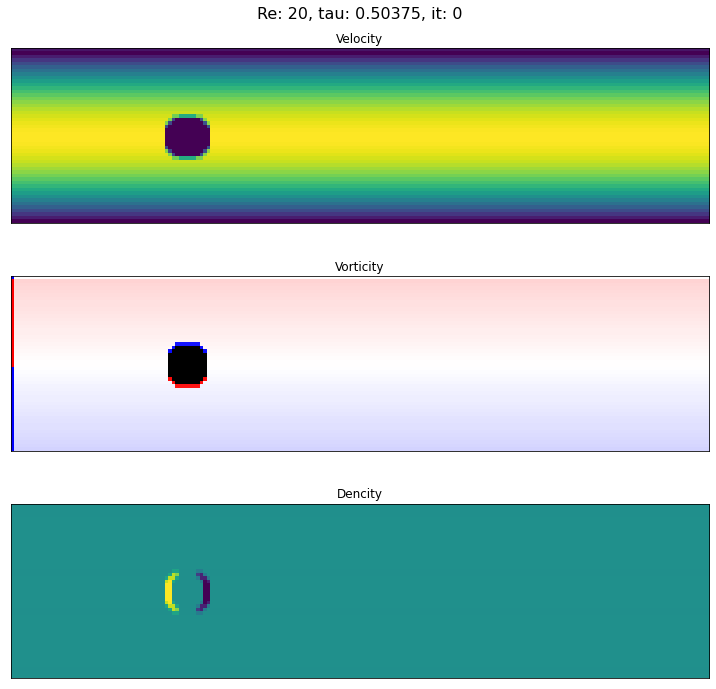

In [374]:
### Simulation(main loop)
cmap = plt.cm.bwr.copy()
cmap.set_bad('black')

RE = [20, 40, 60, 100, 200][2]
res_frame_dir = os.path.join(frames_dir, str(RE))
os.makedirs(res_frame_dir, exist_ok=True)
plot = True
# PRINT = not plot
PRINT = False
macroscopic = True
SAVE_RES = False
if plot:
    fig, axes = plt.subplots(3, figsize=(10, 10))
    fig.suptitle(f'Re: {RE}', fontsize=16)
    for ax in axes:
        ax.invert_yaxis()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_aspect('equal')
    fig.tight_layout()

# F = init_random_cos()
F = init_poiseuille()
# F = init_poiseuille() + init_random_cos() / 10

def print_v(*data):
    if not plot and PRINT:
        print(*data)

MODE = 'tf'
# old - 00:00:47
# np -  01:30:45
# tf -  00:01:40
# tf -  00:00:56  # function optimized
# tfopt 00:00:56  # Optimized via saving

RE = 20
L = NORM_CYLINDER_DIAMETER
u = U_MAX
rho = RHO_0
Re = RE
nu = u * L / Re   # Kinematic viscosity
print(f"nu: {nu}")
tau = 3 * nu + 1/2  # Get relaxation parameters
print(f"tau: {tau}")
TAU = tau

for it in tqdm(range(N_STEPS), disable=plot):
# for it in range(10):

    # Set reflective boundaries
    bndryF = F[CYLINDER_MASK,:]   # shape: (3405, 9)
    # Action: to all cylinder coordinates assign such f_i values
    # can be replaced with mirroring matrix over center
    # bndryF.reshape(-1, 3, 3)[:, ::-1][::-1, :].reshape(-1, 9);
    bndryF = bndryF[:, CYL_BOUNCE_BACK_DIRECTIONS]

    ### 1. Compute moments (for each latice)
    rho = np.sum(F, 2)  # shape: (100, 400)
    ux  = np.sum(F * VECTORS_VELOCITIES_X, 2) / rho   # shape: (100, 400)
    uy  = np.sum(F * VECTORS_VELOCITIES_Y, 2) / rho   # shape: (100, 400)
    if it == 10:
        break
    if macroscopic:
        ### 1.1 Compute macroscopic (dirichlet) boundary conditions
        ##  Inlet: Poiseuille profile
        y_phys = np.arange(LENGTH_Y) - 0.5
        ux[INLET_SL] = poiseuille_profile(y_phys)
        uy[INLET_SL] = 0
        rho[INLET_SL] = 1 / (1 - ux[INLET_SL] * (
            F[INLET_SL][LAT_CENT_COL_SL].sum(axis=1) +
            2 * F[INLET_SL][LAT_LEFT_COL_SL].sum(axis=1))
        )
#         ##  Outlet: Constant pressure
#         print_v('-')
#         print_v("rho outlet before", rho[OUTLET_SL].mean())
#         rho[OUTLET_SL] = 1
#         print_v("rho outlet after", rho[OUTLET_SL].mean())
#         print_v("rho total", rho.mean())
#         print_v("F[OUTLET_SL][LAT_CENT_COL_SL].sum(axis=1)", np.mean(F[OUTLET_SL][LAT_CENT_COL_SL].sum(axis=1)))
#         print_v("2 * F[OUTLET_SL][LAT_RIGHT_COL_SL].sum(axis=1)", np.mean(2 * F[OUTLET_SL][LAT_RIGHT_COL_SL].sum(axis=1)))

#         print_v("ux before", ux[OUTLET_SL].mean())
#         ux[OUTLET_SL] = -1 + 1 / rho[OUTLET_SL] * (
#             F[OUTLET_SL][LAT_CENT_COL_SL].sum(axis=1) +
#             2 * F[OUTLET_SL][LAT_RIGHT_COL_SL].sum(axis=1)
#         )
#         print_v("ux after", ux[OUTLET_SL].mean())
#         uy[OUTLET_SL] = 0

    ### 2. Compute equilibrium
    if MODE == 'old':
        F_eq = calc_ba_eq(F, rho)
    elif MODE == 'np':
        F_eq = calc_np_eq(F)
    elif MODE == 'tf':
        F_eq = calc_tf_eq(F)
    elif MODE == 'tf_opt':
        F_eq = predict(F)

    ### 3. Collide locally
#     F = F - (F - F_eq) / TAU
#     omega = 1.98
    omega = 1 / TAU
    F = (1 - omega) * F + omega * F_eq
#     F = F - omega * F + omega * F_eq = F - omega * (F - F_eq)

    # Apply boundary 
    F[CYLINDER_MASK, :] = bndryF
    
    ### 4. Propagate to the neighbours
    for i, cx, cy in zip(VECTOR_INDEXES, VECTORS_VELOCITIES_X, VECTORS_VELOCITIES_Y):
        F[:, :, i] = np.roll(F[:, :, i], (cx, cy), axis=(1, 0))
        

    if (it % 10 == 0 or it == N_STEPS - 1) or MODE == 'np2' and plot:
        if SAVE_RES:
            fig, axes = plt.subplots(3, figsize=(10, 8))
            fig.suptitle(f'RE: {RE}', fontsize=16)
            for ax in axes:
                ax.invert_yaxis()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                ax.set_aspect('equal')
            fig.tight_layout()
        ux[CYLINDER_MASK] = 0
        uy[CYLINDER_MASK] = 0
        # Note: Calculate vorticity as a difference 
        # Note: np.roll(ux, -1, axis=0) - shift all X velocity by one ROW down
        # vorticity.shape: (100, 400)
        vorticity = (
            (np.roll(ux, -1, axis=0) - np.roll(ux, 1, axis=0)) - 
            (np.roll(uy, -1, axis=1) - np.roll(uy, 1, axis=1))
        )
#         vorticity = vorticity_to_image(vorticity)
        vorticity[CYLINDER_MASK] = np.nan
#         vorticity[CYLINDER_MASK] = 0
        
        # display velocity
        rho = np.sum(F, 2)
        ux  = np.sum(F * VECTORS_VELOCITIES_X, 2) / rho
        uy  = np.sum(F * VECTORS_VELOCITIES_Y, 2) / rho
        u = np.sqrt(ux ** 2 + uy ** 2)
        u[CYLINDER_MASK] = 0
        
        plot_results = [u, vorticity, rho]
    
        fig.suptitle(f'Re: {RE}, tau: {tau:.5f}, it: {it}', fontsize=16)
        for ax, title, img, cmap in zip(axes, titles, plot_results, cmaps):
            ax.cla()
            ax.set_title(f"{title}")
            ax.imshow(img, cmap=cmap)
            if title == 'Vorticity':
                ax.get_images()[0].set_clim(-.1, .1)
        
        
#         axes[0].cla()
#         axes[0].set_title(f"Velocity, it: {it}")
#         axes[0].imshow(u)
        
#         # Works but blink all the time
#         axes[1].cla()
#         axes[1].set_title(f"Vorticity, it: {it}")
#         axes[1].imshow(vorticity, cmap=cmap)
#         axes[1].get_images()[0].set_clim(-.1, .1)
        
#         axes[2].cla()
#         axes[2].set_title(f"Dencity, it: {it}")
#         axes[2].imshow(rho)
        display(fig)
        if SAVE_RES:
            pylab.savefig(os.path.join(res_frame_dir, str(it)))
        clear_output(wait=True)
        plt.pause(0.001)

#         image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
#         image_reshaped = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

In [219]:
for re_dir in os.listdir(frames_dir):
    video_path = os.path.join(video_dir, re_dir + '.mp4')
    re_frames_dir = os.path.join(frames_dir, re_dir)
    if not os.path.isdir(re_frames_dir):
        continue
    with imageio.get_writer(video_path, mode='I') as writer:
        for image_path in sorted(os.listdir(re_frames_dir), key=lambda x: int(x.split('.')[0])):
            image = imageio.imread(os.path.join(re_frames_dir, image_path))
            writer.append_data(image)